# Feature Reduction Notebook

## Objectives 

The model already performs at 100% accuracy, this hypothesis seeks to discover if reducing input complexity by focusing on specific features, such as textures or grayscale, improves computational efficiency without compromising on the performance required by the client of >97% accuracy.


* Answer Business Requirement 2:
    * The client is interested to know if a cherry leaf has powdery mildew or not.

## Inputs
    * inputs/cherry_leaves/cherry-leaves/train
    * inputs/cherry_leaves/cherry-leaves/test
    * inputs/cherry_leaves/cherry-leaves/validation
   

## Outputs 
   
    
## Additional Comments | Insights | Conclusions

## Import Libraries

In [16]:
import datetime
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import TensorBoard
import joblib

## Set Working Directory

In [17]:
current_dir = os.getcwd()
current_dir

'/workspace/P5-Mildew-Detection-in-Cherry-Leaves'

In [18]:
os.chdir('/workspace/P5-Mildew-Detection-in-Cherry-Leaves')
print("You set a new current directory")

You set a new current directory


In [19]:
work_dir = os.getcwd()
work_dir

'/workspace/P5-Mildew-Detection-in-Cherry-Leaves'

## Set Input Directories

In [20]:
my_data_dir = 'inputs/cherry_leaves/cherry-leaves'
test_path = my_data_dir + '/test'
train_path = my_data_dir + '/train'
val_path = my_data_dir + '/validation'

## Set Output Directory

In [21]:
version = 'v2'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(work_dir) and version in os.listdir(work_dir + '/outputs'):
  print('Old version is already available create a new version.')
  pass
else:
  os.makedirs(name=file_path)

Old version is already available create a new version.


## Log Directory

In [22]:
log_dir = f"outputs/{version}/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1, profile_batch='500,520')

2024-12-07 19:53:20.733342: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2024-12-07 19:53:20.733375: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2024-12-07 19:53:20.733932: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


### Set labels

In [23]:
labels = os.listdir(train_path)

print(
    f"Project Labels: {labels}"
    )

Project Labels: ['healthy', 'powdery_mildew']


### Set Greyscale image shape

In [24]:
image_shape = (256, 256, 1)  # Grayscale shape
joblib.dump(value=image_shape, filename=f"{file_path}/image_shape.pkl")

['outputs/v2/image_shape.pkl']

### Data Distribution Visualisation 

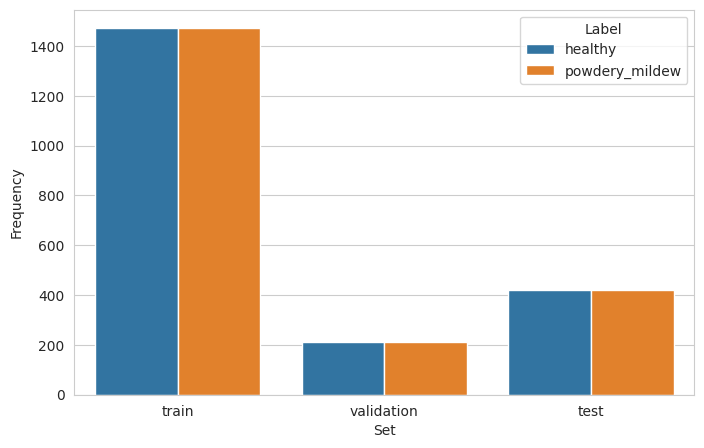

In [25]:
df_freq = pd.DataFrame([])
for folder in ['train', 'validation', 'test']:
    for label in labels:
        df_freq = df_freq.append(
            pd.Series(data={'Set': folder,
                            'Label': label,
                            'Frequency': int(len(os.listdir(my_data_dir + '/' + folder + '/' + label)))}
                      ),
            ignore_index=True
        )
sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))
sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label')
plt.savefig(f'{file_path}/labels_distribution.png', bbox_inches='tight', dpi=150)
plt.show()

## Image Data Augmentation

### Augmentation for Greyscale creation

In [26]:
batch_size = 20
augmented_image_data = ImageDataGenerator(rotation_range=20,
                                          width_shift_range=0.10,
                                          height_shift_range=0.10,
                                          shear_range=0.1,
                                          zoom_range=0.1,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          fill_mode='nearest',
                                          rescale=1./255)

train_set = augmented_image_data.flow_from_directory(train_path,
                                                      target_size=image_shape[:2],
                                                      color_mode='grayscale',
                                                      batch_size=batch_size,
                                                      class_mode='binary',
                                                      shuffle=True)

validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(val_path,
                                                                        target_size=image_shape[:2],
                                                                        color_mode='grayscale',
                                                                        batch_size=batch_size,
                                                                        class_mode='binary',
                                                                        shuffle=False)

test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                                  target_size=image_shape[:2],
                                                                  color_mode='grayscale',
                                                                  batch_size=batch_size,
                                                                  class_mode='binary',
                                                                  shuffle=False)

Found 2944 images belonging to 2 classes.
Found 420 images belonging to 2 classes.
Found 844 images belonging to 2 classes.


(20, 256, 256, 1)


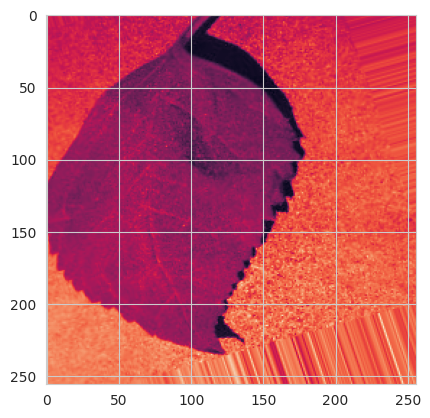

(20, 256, 256, 1)


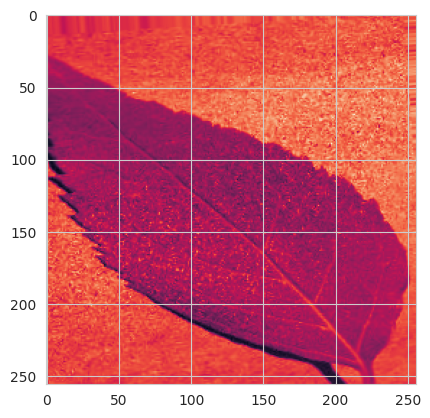

(20, 256, 256, 1)


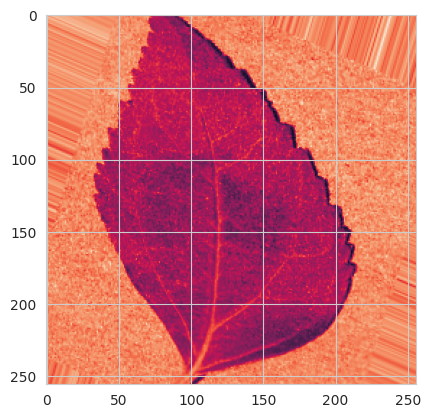

In [27]:
for _ in range(3):
    img, label = train_set.next()
    print(img.shape)   #  (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

### Save class indices

In [28]:
joblib.dump(value=train_set.class_indices, filename=f"{file_path}/class_indices.pkl")

['outputs/v2/class_indices.pkl']

## Model Creation

### Define Model

In [29]:
def create_tf_model_grayscale():
    model = Sequential()
    model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=image_shape, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

### Initialise Model

In [30]:
model = create_tf_model_grayscale()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 57600)             0

2024-12-07 19:54:07.758382: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Set Early Stopping

In [31]:
early_stop = EarlyStopping(monitor='val_loss', patience=3)

### Train Model

In [32]:
history = model.fit(train_set,
                    epochs=25,
                    steps_per_epoch=len(train_set.classes) // batch_size,
                    validation_data=validation_set,
                    callbacks=[early_stop, tensorboard_callback],
                    verbose=1)

2024-12-07 19:54:18.906686: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/25
147/147 [==============================] - 269s 2s/step - loss: 0.3372 - accuracy: 0.8328 - val_loss: 0.0454 - val_accuracy: 0.9929


2024-12-07 19:58:48.449086: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1769472000 exceeds 10% of free system memory.


Epoch 2/25
147/147 [==============================] - 262s 2s/step - loss: 0.0930 - accuracy: 0.9716 - val_loss: 0.0186 - val_accuracy: 0.9952


2024-12-07 20:03:11.553565: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1769472000 exceeds 10% of free system memory.


Epoch 3/25
147/147 [==============================] - 263s 2s/step - loss: 0.0516 - accuracy: 0.9843 - val_loss: 0.0506 - val_accuracy: 0.9857


2024-12-07 20:07:35.853680: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1769472000 exceeds 10% of free system memory.


Epoch 4/25
 58/147 [==========>...................] - ETA: 2:33 - loss: 0.0440 - accuracy: 0.9862

2024-12-07 20:09:17.276417: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2024-12-07 20:09:17.276450: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


 79/147 [===============>..............] - ETA: 1:57 - loss: 0.0374 - accuracy: 0.9892

2024-12-07 20:09:54.062253: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2024-12-07 20:09:54.068156: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2024-12-07 20:09:54.080517: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: outputs/v2/logs/fit/20241207-195320/train/plugins/profile/2024_12_07_20_09_54

2024-12-07 20:09:54.088560: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to outputs/v2/logs/fit/20241207-195320/train/plugins/profile/2024_12_07_20_09_54/katherineho-p5mildewdet-i0djt8i48ey.trace.json.gz
2024-12-07 20:09:54.095199: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: outputs/v2/logs/fit/20241207-195320/train/plugins/profile/2024_12_07_20_09_54

2024-12-07 20:09:54.095276: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz

147/147 [==============================] - 265s 2s/step - loss: 0.0374 - accuracy: 0.9884 - val_loss: 0.0122 - val_accuracy: 0.9952


2024-12-07 20:12:02.444102: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1769472000 exceeds 10% of free system memory.


Epoch 5/25
147/147 [==============================] - 266s 2s/step - loss: 0.0416 - accuracy: 0.9908 - val_loss: 0.0135 - val_accuracy: 0.9905


2024-12-07 20:16:30.454392: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1769472000 exceeds 10% of free system memory.


Epoch 6/25
147/147 [==============================] - 260s 2s/step - loss: 0.0388 - accuracy: 0.9880 - val_loss: 0.0124 - val_accuracy: 0.9976
Epoch 7/25
147/147 [==============================] - 266s 2s/step - loss: 0.0358 - accuracy: 0.9880 - val_loss: 0.0013 - val_accuracy: 1.0000
Epoch 8/25
147/147 [==============================] - 266s 2s/step - loss: 0.0244 - accuracy: 0.9911 - val_loss: 0.0119 - val_accuracy: 0.9952
Epoch 9/25
147/147 [==============================] - 261s 2s/step - loss: 0.0297 - accuracy: 0.9901 - val_loss: 0.0031 - val_accuracy: 1.0000
Epoch 10/25
147/147 [==============================] - 264s 2s/step - loss: 0.0249 - accuracy: 0.9921 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 11/25
147/147 [==============================] - 263s 2s/step - loss: 0.0293 - accuracy: 0.9904 - val_loss: 0.0028 - val_accuracy: 1.0000
Epoch 12/25
147/147 [==============================] - 259s 2s/step - loss: 0.0464 - accuracy: 0.9880 - val_loss: 0.0187 - val_accuracy: 0.9

### Save Model

In [34]:
model.save(f'{file_path}/cherry_leaves_model_grayscale.h5')
print(f"TensorBoard logs saved to: {log_dir}")

TensorBoard logs saved to: outputs/v2/logs/fit/20241207-195320


### Plot Training Results

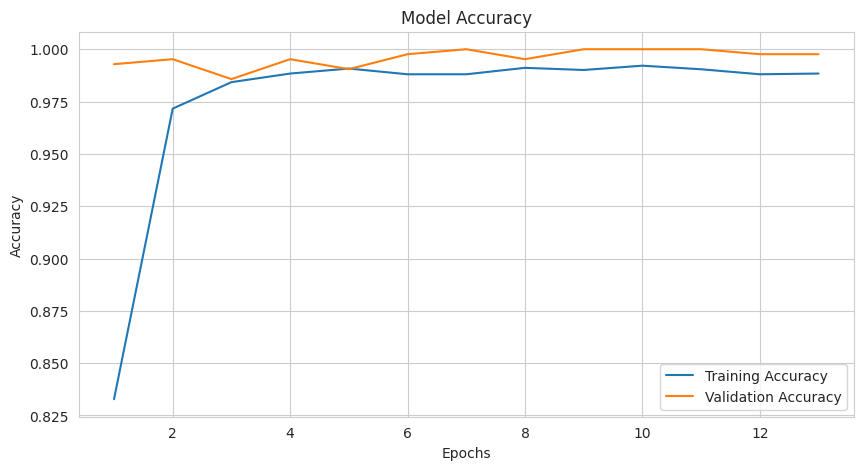

In [35]:
history_df = pd.DataFrame(history.history)
plt.figure(figsize=(10, 5))
sns.lineplot(data=history_df, x=history_df.index + 1, y='accuracy', label='Training Accuracy')
sns.lineplot(data=history_df, x=history_df.index + 1, y='val_accuracy', label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig(f'{file_path}/accuracy_plot.png', bbox_inches='tight', dpi=150)
plt.show()

In [ ]:
%load_ext tensorboard
%tensorboard --logdir outputs/v2/logs/fit

In [40]:
%reload_ext tensorboard